In [1]:
!python -m pip install --upgrade pip
!python -m pip uninstall -y scikit-learn-extra
!python -m pip install "numpy<2.0" --upgrade
!python -m pip install scikit-learn-extra

Found existing installation: scikit-learn-extra 0.3.0
Uninstalling scikit-learn-extra-0.3.0:
  Successfully uninstalled scikit-learn-extra-0.3.0


You can safely remove it manually.


  Using cached scikit_learn_extra-0.3.0-cp311-cp311-win_amd64.whl.metadata (3.7 kB)
Using cached scikit_learn_extra-0.3.0-cp311-cp311-win_amd64.whl (340 kB)


In [2]:
import pandas as pd
import os
import zipfile


zip_path = "CaseStudyDataPY.zip"
data_dir = "CaseStudyDataPY"

# -----------------------------------------------------------------------------
# Create directory and extract CSVs if it doesn't exist
# -----------------------------------------------------------------------------
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(data_dir)


# -----------------------------------------------------------------------------
# Read supplier data
# The first column is used as the supplier index
# -----------------------------------------------------------------------------
Suppliers_df = pd.read_csv(f"{data_dir}/Suppliers.csv", index_col=0)
# Maximum supplier index (assumed to be integer-indexed)
nbSuppliers = Suppliers_df.index.max()


# -----------------------------------------------------------------------------
# Read postcode district data (used to define customers)
# -----------------------------------------------------------------------------
PostcodeDistricts = pd.read_csv(f"{data_dir}/PostcodeDistricts.csv", index_col=0)


# -----------------------------------------------------------------------------
# Read candidate facility data
# -----------------------------------------------------------------------------
Candidates_df = pd.read_csv(f"{data_dir}/Candidates.csv", index_col=0)
# Maximum candidate index
nbCandidates = Candidates_df.index.max()


# -----------------------------------------------------------------------------
# Read distance matrices
# Supplier → District distances
# District → District distances
# Column names are converted from strings to integers for correct .loc indexing
# -----------------------------------------------------------------------------
DistanceSupplierDistrict_df = pd.read_csv(
    f"{data_dir}/Distance Supplier-District.csv", index_col=0
)
DistanceSupplierDistrict_df.columns = DistanceSupplierDistrict_df.columns.astype(int)

DistanceDistrictDistrict_df = pd.read_csv(
    f"{data_dir}/Distance District-District.csv", index_col=0
)
DistanceDistrictDistrict_df.columns = DistanceDistrictDistrict_df.columns.astype(int)


# -----------------------------------------------------------------------------
# Read aggregate demand data (no time dimension)
# Creates a dictionary keyed by (Customer, Product)
# -----------------------------------------------------------------------------
Demand_df = pd.read_csv(f"{data_dir}/Demand.csv")
Demand = (
    Demand_df
        .set_index(["Customer", "Product"])["Demand"]
        .to_dict()
)


# -----------------------------------------------------------------------------
# Read demand data with time periods
# Creates a dictionary keyed by (Customer, Product, Period)
# -----------------------------------------------------------------------------
DemandPeriods_df = pd.read_csv(f"{data_dir}/DemandPeriods.csv")
DemandPeriods = (
    DemandPeriods_df
        .set_index(["Customer", "Product", "Period"])["Demand"]
        .to_dict()
)

# Number of time periods
nbPeriods = DemandPeriods_df["Period"].max()


# -----------------------------------------------------------------------------
# Read demand data with time periods and scenarios
# Creates a dictionary keyed by (Customer, Product, Period, Scenario)
# -----------------------------------------------------------------------------
DemandPeriodsScenarios_df = pd.read_csv(f"{data_dir}/DemandPeriodScenarios.csv")
DemandPeriodsScenarios = (
    DemandPeriodsScenarios_df
        .set_index(["Customer", "Product", "Period", "Scenario"])["Demand"]
        .to_dict()
)

# Number of scenarios
nbScenarios = DemandPeriodsScenarios_df["Scenario"].max()


# =============================================================================
# Index sets
# =============================================================================
Customers  = PostcodeDistricts.index
Candidates = Candidates_df.index
Suppliers  = Suppliers_df.index


# =============================================================================
# Vehicle-related data
# Vehicles are indexed as:
#   1 = 18t trucks
#   2 = 7.5t lorries
#   3 = 3.5t vans
# =============================================================================

# Vehicle capacity in tonnes
VehicleCapacity = {
    1: 9.0,
    2: 2.4,
    3: 1.5
}

# Cost in pounds per mile travelled (fixed cost)
VehicleCostPerMileOverall = {
    1: 1.666,
    2: 1.727,
    3: 1.285
}

# Cost in pounds per mile and tonne transported (variable cost)
VehicleCostPerMileAndTonneOverall = {
    1: 0.185,
    2: 0.720,
    3: 0.857
}

# CO₂ emissions in kg per mile and tonne transported
VehicleCO2PerMileAndTonne = {
    1: 0.11,
    2: 0.31,
    3: 0.30
}


# -----------------------------------------------------------------------------
# Time periods and scenarios
# -----------------------------------------------------------------------------
Times = range(1, nbPeriods + 1)
Scenarios = range(1, nbScenarios + 1)


# =============================================================================
# Transport cost calculations
# =============================================================================

# Cost from suppliers to candidate facilities
# Round-trip distance (factor 2)
# Cost depends on supplier vehicle type
# Division by 1000 converts from kg to tonnes
CostSupplierCandidate = {
    (k, j): 2
    * DistanceSupplierDistrict_df.loc[k, j]
    * VehicleCostPerMileAndTonneOverall[
        Suppliers_df.loc[k, "Vehicle type"]
    ]
    / 1000
    for j in Candidates
    for k in Suppliers
}

# Cost from candidate facilities to customers
# All transports use 3.5t vans (vehicle type 3)
CostCandidateCustomers = {
    (j, i): 2
    * DistanceDistrictDistrict_df.loc[j, i]
    * VehicleCostPerMileAndTonneOverall[3]
    / 1000
    for j in Candidates
    for i in Customers
}

In [10]:
from sklearn_extra.cluster import KMedoids
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from collections import defaultdict

In [4]:
# Create cost matrix for candidate-customer costs

cand_index = {j: r for r, j in enumerate(Candidates)}
cust_index = {i: c for c, i in enumerate(Customers)}

M, N = len(Candidates), len(Customers)
C = np.empty((M, N), dtype=float)

for (j, i), cost in CostCandidateCustomers.items():
    C[cand_index[j], cust_index[i]] = float(cost)


X = C.T  # shape (N customers, M candidates)
X = X - X.mean(axis=1, keepdims=True) # Centering the data (track which candidates are relatively cheaper for each customer, deals with scale differences)

# Compute customer-customer distance matrix using the formula D² = sq + sq.T - 2*G
G = X @ X.T
sq = np.sum(X**2, axis=1, keepdims=True)
D2 = sq + sq.T - 2*G
D2 = np.maximum(D2, 0)
D = np.sqrt(D2)   # shape (N, N)

#w = Demand_df.to_numpy().sum(axis=1)  # Total demand per customer (shape (N,))

print("candidate-customer cost matrix C:")
print(C)
print("Customer-Customer Price Distance Matrix D:")
print(D)


# One weight per customer = total demand across products
w_series = Demand_df.groupby("Customer")["Demand"].sum()
w = w_series.reindex(Customers).to_numpy()

w_series.index = w_series.index.astype(int)
w = w_series.reindex([int(c) for c in Customers]).to_numpy() # total demand per customer, aligned with Customers index

#weighted_distortion = np.sum(w * D[np.arange(len(D)), medoids[labels]])
#print("Weighted distortion:", weighted_distortion)
print(w)

candidate-customer cost matrix C:
[[0.         0.0021425  0.00622182 ... 0.27787368 0.29938438 0.31618158]
 [0.00262242 0.         0.0077987  ... 0.27943342 0.30094412 0.31775846]
 [0.00654748 0.00752446 0.         ... 0.27293736 0.29444806 0.31124526]
 ...
 [0.27840502 0.279382   0.27350298 ... 0.         0.02353322 0.04034756]
 [0.3000357  0.30101268 0.29513366 ... 0.02355036 0.         0.0203966 ]
 [0.31676434 0.31772418 0.3118623  ... 0.040279   0.02034518 0.        ]]
Customer-Customer Price Distance Matrix D:
[[7.30004830e-08 2.29635018e-02 1.43272930e-01 ... 2.89168750e+00
  2.93652439e+00 2.99275895e+00]
 [2.29635018e-02 5.96046448e-08 1.54499440e-01 ... 2.90080395e+00
  2.94555467e+00 3.00168706e+00]
 [1.43272930e-01 1.54499440e-01 0.00000000e+00 ... 2.77911650e+00
  2.82474879e+00 2.88190126e+00]
 ...
 [2.89168750e+00 2.90080395e+00 2.77911650e+00 ... 0.00000000e+00
  1.20801184e-01 2.43730181e-01]
 [2.93652439e+00 2.94555467e+00 2.82474879e+00 ... 1.20801184e-01
  5.96046448

In [5]:
# K-medoids clustering using sklearn-extra
def fit_kmedoids(D, K, random_state=0):
    """
    Returns: medoids (K,), labels (N,), inertia (float).
    Uses sklearn-extra if installed, else fallback.
    """
    from sklearn_extra.cluster import KMedoids
    kmed = KMedoids(
        n_clusters=K,
        metric="precomputed",
        init="k-medoids++",
        random_state=random_state
    )
    labels = kmed.fit_predict(D)
    medoids = kmed.medoid_indices_
    inertia = float(kmed.inertia_)
    return medoids, labels, inertia



def compute_k_stats(D, Ks, w=None, n_seeds=5, base_seed=0):
    """
    Computes for each K:
      - wcss (inertia)
      - weighted_distortion (sum_i w_i * D[i, medoid_of_i])  [if w provided]
      - max_dev (max_i D[i, medoid_of_i])
      - stability_cv (std(inertia across seeds) / mean(inertia across seeds))
    Returns a dict of arrays.
    """
    D = np.asarray(D, dtype=float)
    N = D.shape[0]
    Ks = list(Ks)

    if w is not None:
        w = np.asarray(w, dtype=float)
        if w.shape != (N,):
            raise ValueError(f"w must have shape {(N,)}, got {w.shape}")
        w = np.maximum(w, 0.0)

    wcss = []
    weighted_distortion = []
    max_dev = []
    stability_cv = []

    for K in Ks:
        # main run (seed = base_seed)
        medoids, labels, inertia = fit_kmedoids(D, K, random_state=base_seed)

        d_assigned = D[np.arange(N), medoids[labels]]
        wcss.append(inertia)
        max_dev.append(float(np.max(d_assigned)))

        if w is None:
            weighted_distortion.append(np.nan)
        else:
            weighted_distortion.append(float(np.sum(w * d_assigned)))

        # stability: run multiple seeds and compute CV of inertia
        inertias = []
        for s in range(n_seeds):
            _, _, inertia_s = fit_kmedoids(D, K, random_state=base_seed + s + 1)
            inertias.append(inertia_s)

        inertias = np.array(inertias, dtype=float)
        cv = float(np.std(inertias) / np.mean(inertias)) if np.mean(inertias) > 0 else np.nan
        stability_cv.append(cv)

    return {
        "K": np.array(Ks, dtype=int),
        "wcss": np.array(wcss, dtype=float),
        "weighted_distortion": np.array(weighted_distortion, dtype=float),
        "max_dev": np.array(max_dev, dtype=float),
        "stability_cv": np.array(stability_cv, dtype=float),
    }


{'K': array([ 40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100]), 'wcss': array([84.05870586, 77.38721885, 71.4867377 , 65.2358693 , 61.7129409 ,
       58.45398855, 55.0824673 , 51.65642533, 49.34380554, 47.5093797 ,
       45.31493112, 43.48337237, 41.31092577]), 'weighted_distortion': array([7998272.99543592, 7733369.50493   , 7078105.88939209,
       6403422.44759224, 6014207.18366528, 5883808.64400336,
       5433658.92850342, 4955773.3066855 , 5024414.75599339,
       4913200.83205318, 4599464.76991168, 4565738.95494108,
       4238691.8759182 ]), 'max_dev': array([0.75717714, 0.79130277, 0.79130277, 0.59713586, 0.59713586,
       0.50352093, 0.46573811, 0.46573811, 0.46125201, 0.46125201,
       0.39385235, 0.37275007, 0.37275007]), 'stability_cv': array([0.01584992, 0.01639456, 0.0081775 , 0.01449403, 0.00800752,
       0.00669222, 0.01058158, 0.01059302, 0.01517278, 0.01268753,
       0.01292717, 0.01385091, 0.00775503])}


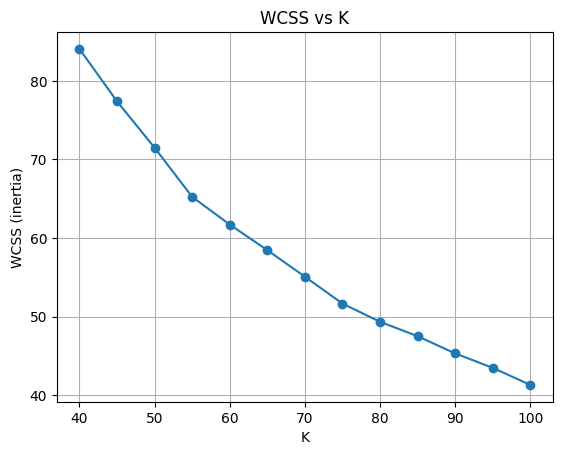

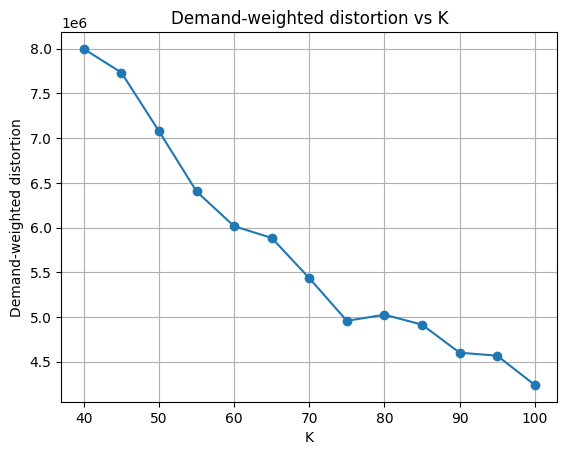

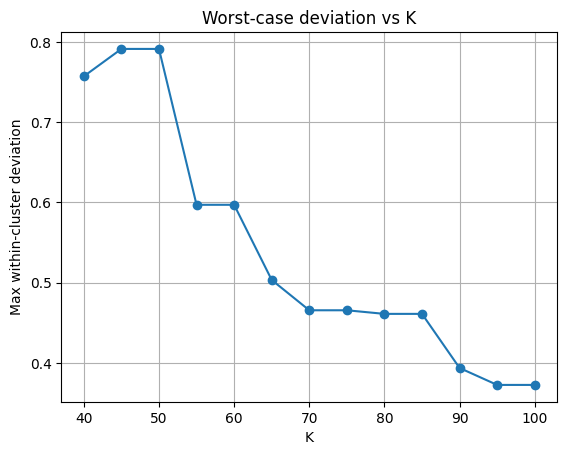

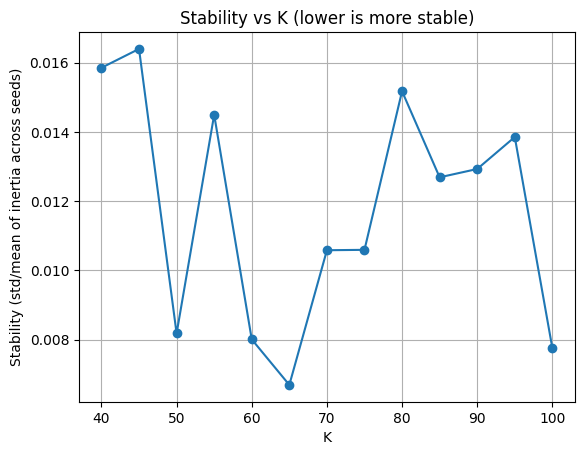

In [6]:
#Ks = [10, 20, 30, 40, 60, 80, 100, 120, 160, 200]
Ks = list(range(40, 101, 5))

w = w


stats = compute_k_stats(D, Ks, w=w, n_seeds=5, base_seed=0)
print(stats)


K = stats["K"]

# 1) WCSS
plt.figure()
plt.plot(K, stats["wcss"], marker="o")
plt.xlabel("K")
plt.ylabel("WCSS (inertia)")
plt.title("WCSS vs K")
plt.grid(True)
plt.show()

# 2) Demand-weighted distortion (if w provided)
if np.isfinite(stats["weighted_distortion"]).any():
    plt.figure()
    plt.plot(K, stats["weighted_distortion"], marker="o")
    plt.xlabel("K")
    plt.ylabel("Demand-weighted distortion")
    plt.title("Demand-weighted distortion vs K")
    plt.grid(True)
    plt.show()

# 3) Max within-cluster deviation
plt.figure()
plt.plot(K, stats["max_dev"], marker="o")
plt.xlabel("K")
plt.ylabel("Max within-cluster deviation")
plt.title("Worst-case deviation vs K")
plt.grid(True)
plt.show()

# 4) Stability (CV of inertia across seeds)
plt.figure()
plt.plot(K, stats["stability_cv"], marker="o")
plt.xlabel("K")
plt.ylabel("Stability (std/mean of inertia across seeds)")
plt.title("Stability vs K (lower is more stable)")
plt.grid(True)
plt.show()


In [7]:
Ks = np.array(Ks, dtype=float)
#J = np.array(stats["wcss"], dtype=float)
J = np.array(stats["weighted_distortion"], dtype=float)
#J = np.array(stats["max_dev"], dtype=float)
#J = np.array(stats["stability_cv"], dtype=float)

# normalize to [0,1]
x = (Ks - Ks.min()) / (Ks.max() - Ks.min())
y = (J - J.min()) / (J.max() - J.min())

# distance from line connecting (0, y0) to (1, y1)
x0, y0 = x[0], y[0]
x1, y1 = x[-1], y[-1]

# line distance formula
num = np.abs((y1 - y0)*x - (x1 - x0)*y + x1*y0 - y1*x0)
den = np.sqrt((y1 - y0)**2 + (x1 - x0)**2)

dist = num / den
K_star = int(Ks[np.argmax(dist)])
print("Chosen K (max curvature):", K_star)


Chosen K (max curvature): 75


In [8]:
K = 75

kmed = KMedoids(
    n_clusters=K,
    metric="precomputed",   # IMPORTANT
    init="k-medoids++",
    random_state=0
)

labels = kmed.fit_predict(D)
medoids = kmed.medoid_indices_

wcss = kmed.inertia_
print(wcss)
print(labels)
print(medoids)

51.65642532554968
[ 2  2  2  2  2  2  2  2  2  2  2  2 36  2  2 69 69 42 69 68 31  2 56 56
 44 23 23 56 44 44 23 31 31  8  8  8  8  8  8  8  8 36 36  8 17 17 17 17
 17 57 57 57 64 40 40 40 40 40 59 59 59 59 59 59 59 59 59  4 59 59  4 59
  4  4  4  4  4  4  4  4 33  4  4  4 59 59 59 59 33 33 33 33 33 33 33 33
 33 33 33 33 63 63 63 63 28 28 46 46 59 59 28 28 46 46 46 71 46 46  6  6
  6  6  6  6  6  6  6  6 53 24 24 43 24 66 66 39 39 66 39 39 39 39 39 39
  0 39 39  0  0  0  0  0 66 66 66 66 66 66 39 39 66 39 39 39 50 39 71  0
 71 71  0  0  0  0  0 66 66 66 10 39 50 50 50 25 25 25 25 49 49 49 49 49
 51 51 51 27 27 51 51 51 51 51  1 11 11 34 51 51  1  1  1  1 34 34 34  1
  1 34  1  1 31 31 31 11 58 74 74 26 26 26 26  5  5 74  5 58 58 45  5  5
 55 13 64 13 13 64 64 64 64 64 64 32 32 32 32 32 13 13 13 64 32 32 32 32
 32 32 64 30 67 67 67 15 15 15 15 15 15 15  1  1 15 15 15 15 54 54 54 21
 21 21 21 21 35 35 35 35 35 21 46 21 35 35 35 73 73 73 73  0 71 73 73 73
 73 73 60 10 10 10 39 10 10 10 10

In [9]:
K = len(medoids)
clusters = [np.where(labels == k)[0] for k in range(K)]

# Map Customer ID -> position index (0..N-1) consistent with labels/D/C
cust_to_idx = {cust_id: idx for idx, cust_id in enumerate(Customers)}

# Map Customer ID -> cluster id
cust_to_cluster = {cust_id: int(labels[cust_to_idx[cust_id]]) for cust_id in Customers}

print(K)
print(len(clusters))
print(cust_to_idx)
print(cust_to_cluster)

75
75
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117, 119: 118, 120: 119, 121: 120, 1

In [11]:
cluster_to_customers = defaultdict(list)

for cust, cl in cust_to_cluster.items():
    cluster_to_customers[cl].append(cust)

# Print nicely
for cl in sorted(cluster_to_customers.keys()):
    print(f"Cluster {cl} = {sorted(cluster_to_customers[cl])}")


Cluster 0 = [145, 148, 149, 150, 151, 152, 168, 171, 172, 173, 174, 175, 308]
Cluster 1 = [203, 209, 210, 211, 212, 216, 217, 219, 220, 279, 280]
Cluster 2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 22]
Cluster 3 = [353, 416, 424, 425]
Cluster 4 = [68, 71, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84]
Cluster 5 = [232, 233, 235, 239, 240, 423]
Cluster 6 = [119, 120, 121, 122, 123, 124, 125, 126, 127, 128]
Cluster 7 = [349, 350, 352]
Cluster 8 = [34, 35, 36, 37, 38, 39, 40, 41, 44]
Cluster 9 = [355, 356, 357, 358, 359, 360, 361, 362, 363]
Cluster 10 = [179, 316, 317, 318, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 334]
Cluster 11 = [204, 205, 224]
Cluster 12 = [339, 340, 341, 342, 347]
Cluster 13 = [242, 244, 245, 257, 258, 259]
Cluster 14 = [365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 382]
Cluster 15 = [272, 273, 274, 275, 276, 277, 278, 281, 282, 283, 284]
Cluster 16 = [411, 414]
Cluster 17 = [45, 46, 47, 48, 49]
Cluster 18 = [391, 

In [12]:
dem = DemandPeriods_df.copy()
dem["Cluster"] = dem["Customer"].map(cust_to_cluster)

DemandAgg_df = (
    dem.groupby(["Cluster", "Product", "Period"], as_index=False)["Demand"]
       .sum()
)

print(DemandAgg_df.head(100))
print(len(DemandAgg_df))


    Cluster  Product  Period  Demand
0         0        1       1   38536
1         0        1       2   84071
2         0        1       3  122400
3         0        1       4  170111
4         0        1       5  206594
..      ...      ...     ...     ...
95        2        2       6  115288
96        2        2       7  142654
97        2        2       8  156913
98        2        2       9  176821
99        2        2      10  197921

[100 rows x 4 columns]
3000


In [13]:
C = np.asarray(C, dtype=float)               # (M,N)
labels = np.asarray(labels, dtype=int)       # (N,)
w = np.asarray(w, dtype=float)               # (N,)

M, N = C.shape

# Build weighted membership matrix A of shape (N, K):
# A[i,k] = w[i] if customer i is in cluster k else 0
A = np.zeros((N, K), dtype=float)
A[np.arange(N), labels] = w

# Denominator: total weight per cluster
denom = A.sum(axis=0)                        # (K,)

# Numerator: for each candidate j and cluster k, sum_i C[j,i] * A[i,k]
num = C @ A                                  # (M,K)

# Weighted average cost
C_agg = np.divide(num, denom, out=np.zeros_like(num), where=denom > 0)  # (M,K)

print("C_agg shape:", C_agg.shape)           # (440, K)
print("Any empty clusters?", np.any(denom == 0))

print(C_agg[:5])

C_agg shape: (440, 75)
Any empty clusters? False
[[0.24603354 0.24939069 0.0088303  0.30747304 0.22247203 0.38329582
  0.20183794 0.30221478 0.10425197 0.43260798 0.27446013 0.13859569
  0.29862001 0.28719667 0.35689293 0.35794989 0.24414714 0.35859789
  0.17185465 0.31819635 0.28482456 0.17278318 0.17272189 0.08353344
  0.2143865  0.49317418 0.35222624 0.20142809 0.21461195 0.37009434
  0.41005736 0.11190092 0.29577122 0.24212737 0.27263384 0.14487028
  0.0600744  0.13678642 0.40894644 0.25252264 0.35252505 0.36160432
  0.07844978 0.25858055 0.06498644 0.29580212 0.20594462 0.12102956
  0.36847572 0.50263458 0.25087357 0.18879657 0.2523758  0.18350314
  0.45427433 0.21080486 0.03763364 0.40609662 0.31151439 0.20606399
  0.25483752 0.32776822 0.34345132 0.24728399 0.33496918 0.30291522
  0.25656352 0.30320462 0.1146666  0.05122805 0.30588664 0.23283539
  0.14303917 0.24860007 0.33276955]
 [0.24760275 0.24928653 0.00934784 0.30908331 0.22404556 0.38319298
  0.20341184 0.30379166 0.10582

In [17]:
# Copy + map customers to clusters
dems = DemandPeriodsScenarios_df.copy()
dems["Cluster"] = dems["Customer"].map(cust_to_cluster)

# Aggregate to cluster level for each scenario
DemandAgg_all = (
    dems.groupby(["Cluster", "Product", "Period", "Scenario"], as_index=False)["Demand"]
        .sum()
        .sort_values(["Cluster", "Product", "Period", "Scenario"])
)

# Build the four scenario subsets
DemandAgg_10  = DemandAgg_all[DemandAgg_all["Scenario"] <= 10].copy()
#DemandAgg_20  = DemandAgg_all[DemandAgg_all["Scenario"] <= 20].copy()
#DemandAgg_50  = DemandAgg_all[DemandAgg_all["Scenario"] <= 50].copy()
#DemandAgg_100 = DemandAgg_all.copy()   # all scenarios

#print(len(DemandAgg_10), len(DemandAgg_20), len(DemandAgg_50), len(DemandAgg_100))
print(DemandAgg_10.head(20))


     Cluster  Product  Period  Scenario  Demand
0          0        1       1         1   41862
1          0        1       1         2   38048
2          0        1       1         3   38768
3          0        1       1         4   37453
4          0        1       1         5   39656
5          0        1       1         6   37601
6          0        1       1         7   35351
7          0        1       1         8   35863
8          0        1       1         9   36723
9          0        1       1        10   36518
100        0        1       2         1   95030
101        0        1       2         2   85446
102        0        1       2         3   81004
103        0        1       2         4   91170
104        0        1       2         5   84477
105        0        1       2         6   92606
106        0        1       2         7   68533
107        0        1       2         8   75685
108        0        1       2         9   73918
109        0        1       2        10 

In [19]:
DemandAgg_df.to_csv("DemandAgg.csv", index=False)
DemandAgg_10.to_csv("DemandAggScenarios_10.csv", index=False)